## # Validation script for El Salvador 

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

## Yield Data

In [2]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'SV', 'El Salvador'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
df = df[
    (df['season_name'] == 'Annual harvest') &
    (df['product'].isin(['Maize']))
]
area = df[df['indicator'] == 'area']
area['year'] = area['harvest_year']
area = area.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')

prod = df[df['indicator'] == 'production']
prod['year'] = prod['harvest_year']
prod = prod.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
data = prod/area
# ---------------------------------------------------- #
data

year
1998    1.644500
1999    1.890462
2000    2.483992
2001    2.230011
2002    1.927994
2003    2.583882
2004    2.752701
2005    2.769788
2006    2.949458
2007    3.090595
2010    3.012059
2011    3.036342
2013    3.268823
2015    2.584892
2017    3.096719
2018    3.198334
Name: FDW, dtype: float64

## Annual harvest maize season comparison to FAO

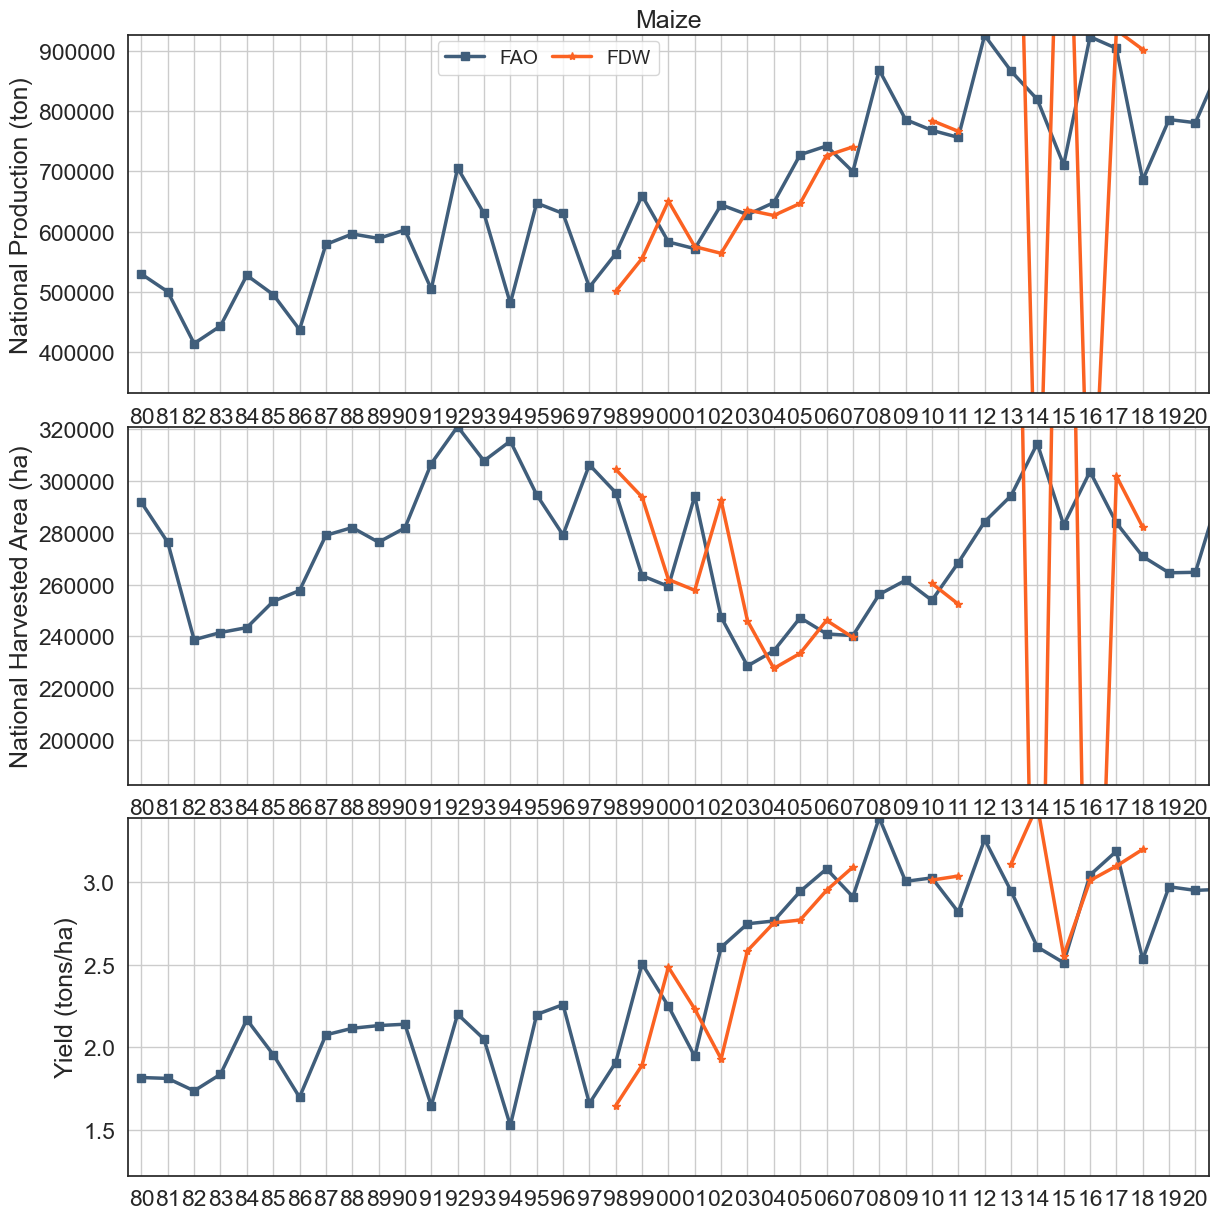

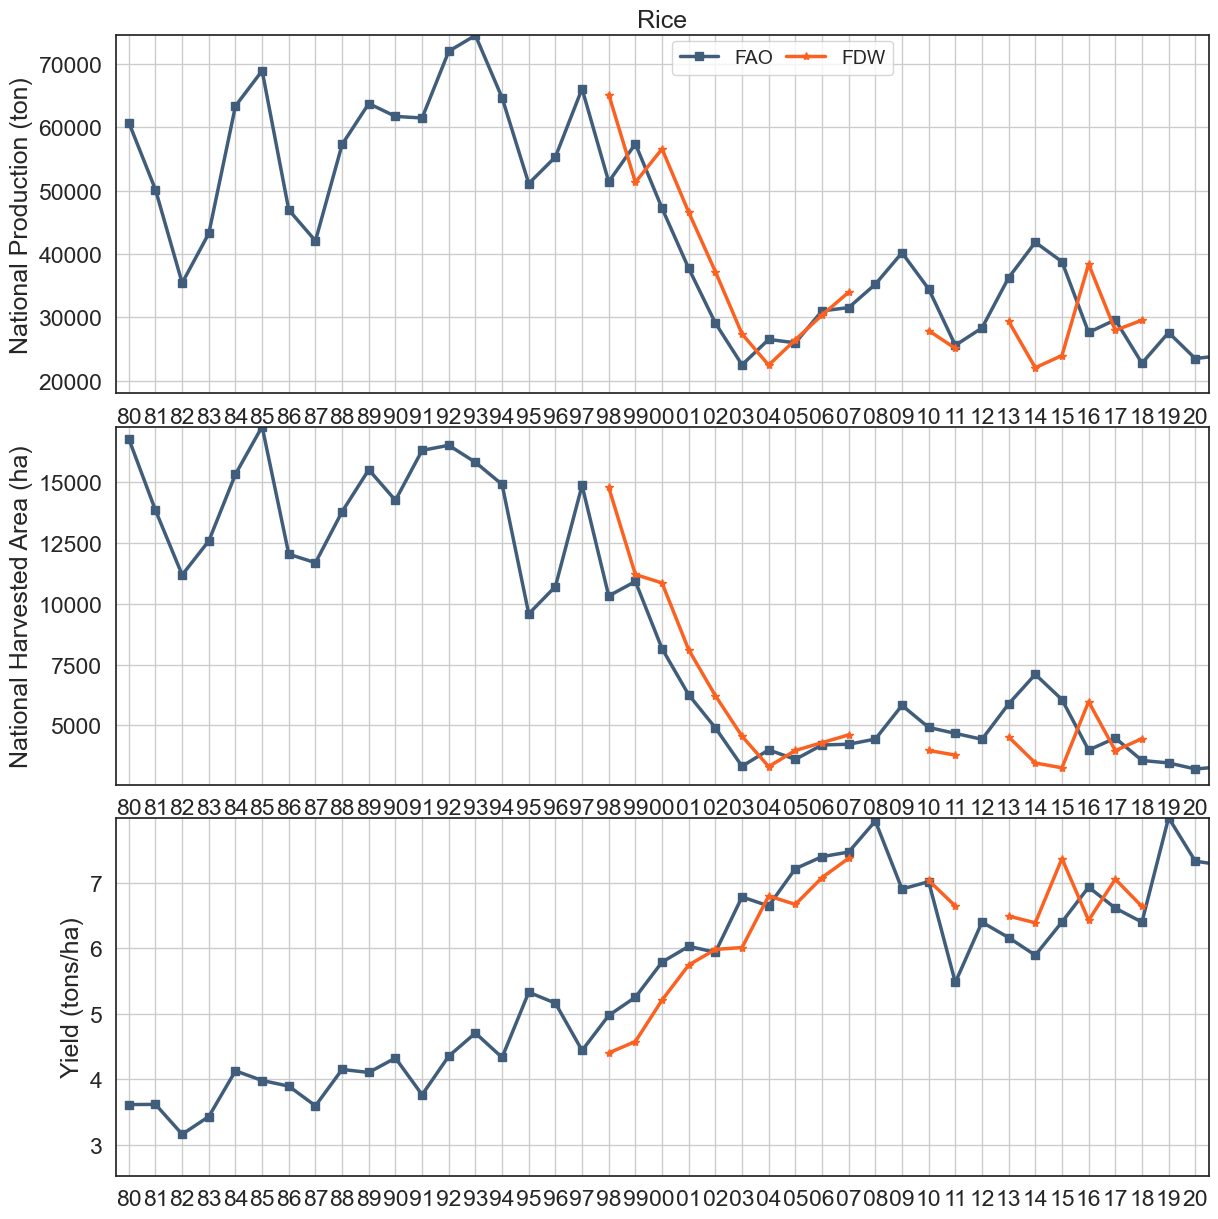

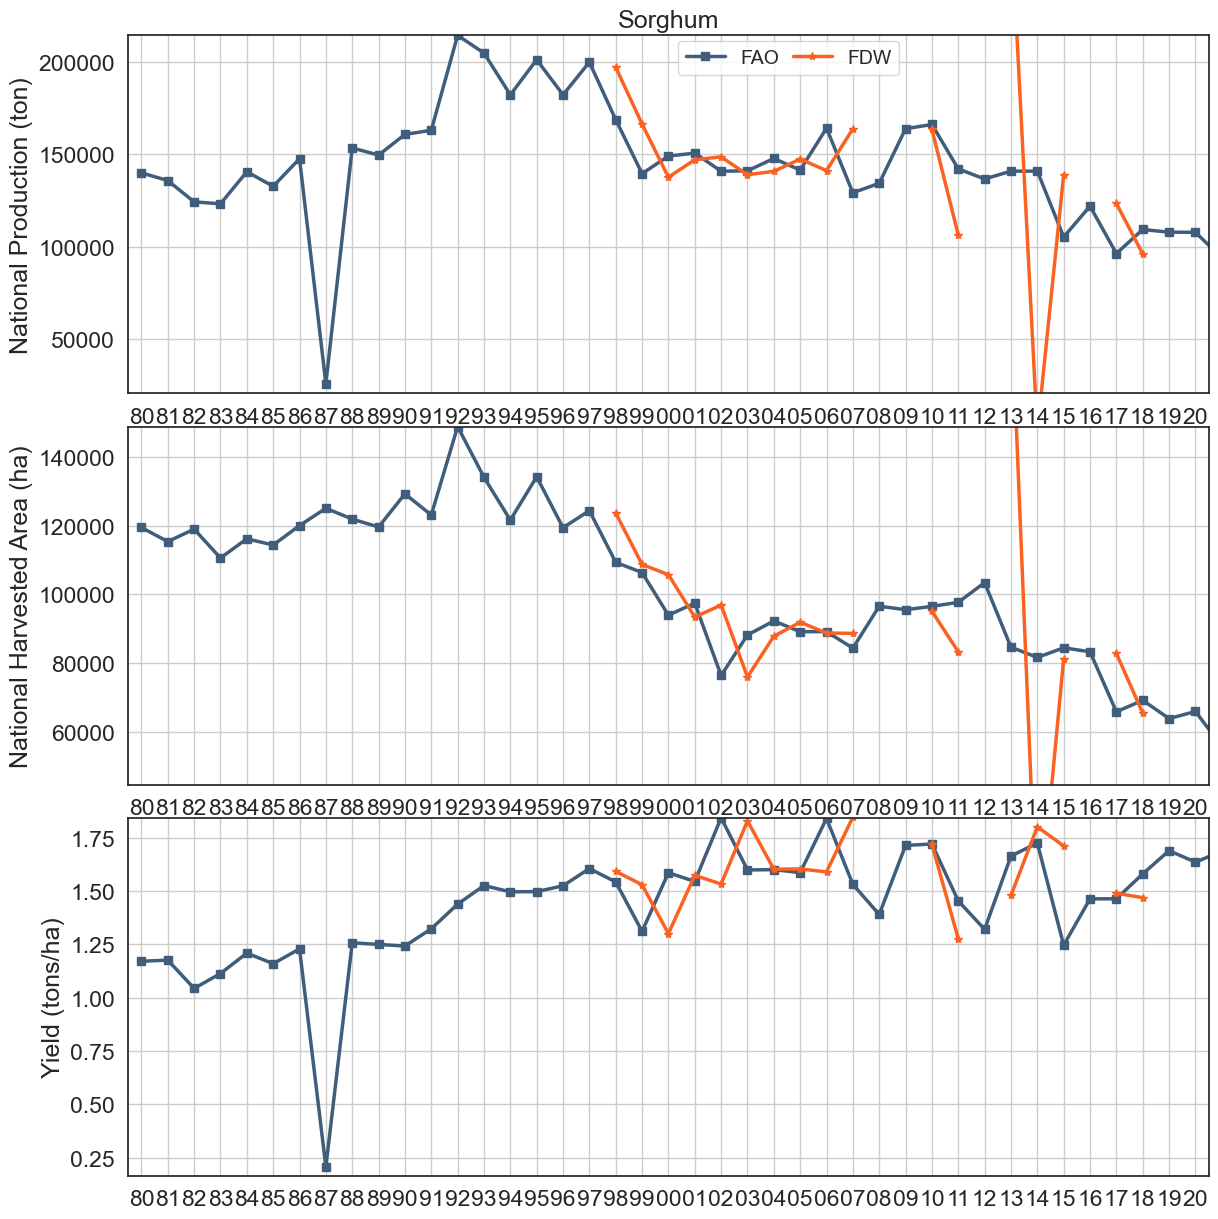

In [3]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name ='SV', 'El Salvador'
df1 = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df1 = df1[df1['gscd_code']=='calibrated']; fnids = list(df1['fnid'].unique())


# Load FAO-STAT National Production Data ------------- #
df2 = pd.read_csv('../data/crop/fao.csv', index_col=0)

product_season = [
#     ['Maize','Primera'],
#     ['Maize','Postrera'],
#     ['Maize','Apante'],
    ['Maize','Annual harvest','Maize (corn)'],
    ['Rice','Annual harvest','Rice'],
#     ['Sorghum','Postrera'],
#     ['Sorghum','Apante'],
#     ['Sorghum','Primera'],
    ['Sorghum','Annual harvest','Sorghum'],
]
for ps in product_season:
    df = df1[
#         (df1['season_name'] == ps[1]) &
        (df1['product'].isin([ps[0]])) &
        (df1['indicator'] == 'production')
        ]
    df['year'] = df['harvest_year']
    data_fdw_pr = df.pivot_table(index='year', columns='product', values='value', aggfunc='sum').sum(1).rename('FDW')
    # ---------------------------------------------------- #

    data_fao = df2[
        (df2['Area'] == 'El Salvador') &
        (df2['Item'] == ps[2]) &
        (df2['Element'] == 'Production')
        ].set_index('Year')['Value']
    # ---------------------------------------------------- #
    data = pd.concat([data_fao, data_fdw_pr], axis=1, keys=['FAO', 'FDW']).sort_index()

    # Validation figure ---------------------------------- #
    years = np.arange(1980, 2021)
    sns.set(style="white", font_scale=1.5)
    fig = plt.figure(figsize=(12, 12))
    ax1 = plt.subplot(311)
    plt.title(ps[0])
    data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B', '#FB6222', '#17AB6F'])
    marker = ['s', '*']
    for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
    ax1.set_xlim([years.min() - 0.5, years.max() + 0.5])
    ax1.set_ylim([np.min(data_fao) - (.2 * np.min(data_fao)), np.max(data_fao)])
    ax1.set_xticks(years)
    ax1.set_xticklabels(['%02d' % yr for yr in np.mod(years, 100)])
    ax1.xaxis.grid(True)
    ax1.grid(True)
    ax1.set_xlabel('')
    ax1.set_ylabel('National Production (ton)')

    ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)

    # ---------------------------------------------------- #

    df = df1[
#         (df1['season_name'] == ps[1]) &
        (df1['product'].isin([ps[0]])) &
        (df1['indicator'] == 'area')
        ]
    df['year'] = df['harvest_year']
    data_fdw_a = df.pivot_table(index='year', columns='product', values='value', aggfunc='sum').sum(1).rename('FDW')
    # ---------------------------------------------------- #

    data_fao = df2[
        (df2['Area'] == 'El Salvador') &
        (df2['Item'] == ps[2]) &
        (df2['Element'] == 'Area harvested')
        ].set_index('Year')['Value']
    # ---------------------------------------------------- #
    data = pd.concat([data_fao, data_fdw_a], axis=1, keys=['FAO', 'FDW']).sort_index()

    # Validation figure ---------------------------------- #
    ax2 = plt.subplot(312)
    data.plot(ax=ax2, legend=None, linewidth=2.5, marker='s', color=['#405E7B', '#FB6222', '#17AB6F'])
    marker = ['s', '*']
    for i, line in enumerate(ax2.get_lines()): line.set_marker(marker[i])
    ax2.set_xlim([years.min() - 0.5, years.max() + 0.5])
    ax2.set_ylim([np.min(data_fao) - (.2 * np.min(data_fao)), np.max(data_fao)])
    ax2.set_xticks(years)
    ax2.set_xticklabels(['%02d' % yr for yr in np.mod(years, 100)])
    ax2.xaxis.grid(True)
    ax2.grid(True)
    ax2.set_xlabel('')
    ax2.set_ylabel('National Harvested Area (ha)')

    # ---------------------------------------------------- #

    data_fdw = data_fdw_pr / data_fdw_a
    # ---------------------------------------------------- #

    data_fao = df2[
                   (df2['Area'] == 'El Salvador') &
                   (df2['Item'] == ps[2]) &
                   (df2['Element'] == 'Yield')
                   ].set_index('Year')['Value'] / 10000  # convert hg/ha to tons/ha
    # ---------------------------------------------------- #
    data = pd.concat([data_fao, data_fdw], axis=1, keys=['FAO', 'FDW']).sort_index()

    # Validation figure ---------------------------------- #
    ax3 = plt.subplot(313)
    data.plot(ax=ax3, legend=None, linewidth=2.5, marker='s', color=['#405E7B', '#FB6222', '#17AB6F'])
    marker = ['s', '*']
    for i, line in enumerate(ax3.get_lines()): line.set_marker(marker[i])
    ax3.set_xlim([years.min() - 0.5, years.max() + 0.5])
    ax3.set_ylim([np.min(data_fao) - (.2 * np.min(data_fao)), np.max(data_fao)])
    ax3.set_xticks(years)
    ax3.set_xticklabels(['%02d' % yr for yr in np.mod(years, 100)])
    ax3.xaxis.grid(True)
    ax3.grid(True)
    ax3.set_xlabel('')
    ax3.set_ylabel('Yield (tons/ha)')

    plt.tight_layout(pad=0)
    plt.show()


